In [80]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
from numpy import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import random

import sys
import pickle
import time
import platform

In [3]:
ttype = torch.FloatTensor         # For CPU
torch.set_num_threads(8)
# ttype = torch.cuda.FloatTensor  # For GPU

In [4]:
torch.get_num_threads()

8

# Get images

In [56]:
imagedata = np.zeros((0, 1024 * 3))

for numfile in range(4):
    with open('cifar-10-batches-py/data_batch_' + str(numfile + 1), 'rb') as fo:
        imagedict = pickle.load(fo, encoding='bytes')  # Python 3
    imagedata = np.concatenate((imagedata, imagedict[b'data']), axis=0)

np.set_printoptions(precision=4)

# Define parameters

In [89]:
defaultParams = {
    'nbpatterns': 3,  # number of images per episode
    'nbprescycles': 3,  # number of presentations for each image
    'prestime': 20,  # number of time steps for each image presentation
    'prestimetest': 5,  # number of time steps for the test (degraded) image
    'interpresdelay': 2,  # number of time steps (with zero input) between two presentations
    'patternsize': 1024,  # size of the images (32 x 32 = 1024)
    'nbiter': 100000,  # number of episodes

    # when contiguousperturbation is False (which it shouldn't be),
    # probability of zeroing each pixel in the test image
    'probadegrade': .5,

    'lr': 1e-4,  # Adam learning rate
    'print_every': 10,  # how often to print statistics and save files
    'homogenous': 0,  # whether alpha should be shared across connections
    'rngseed': 0  # random seed
}

# Generate inputs and target

In [77]:
def generate_inputs_and_target(params, contiguousperturbation=True):
    input_tensor = np.zeros((params['nbsteps'], 1, params['nbneur']))  # inputTensor, initially in numpy format...

    # Create the random patterns to be memorized in an episode
    # Floating-point, graded patterns, zero-mean
    patterns = []
    for nump in range(params['nbpatterns']):
        numpic = np.random.randint(imagedata.shape[0])
        p = imagedata[numpic].reshape((3, 1024)).sum(0).astype(float)
        p = p[:params['patternsize']]
        p = p - np.mean(p)
        p = p / (1e-8 + np.max(np.abs(p)))
        # p = (np.random.randint(2, size=params['patternsize']) - .5) *2   # Binary patterns
        patterns.append(p)

    # Now 'patterns' contains the NBPATTERNS patterns to be memorized in this episode - in numpy format
    # Creating the test pattern, partially zero'ed out, that the network will have to complete
    testpattern = random.choice(patterns).copy()
    preservedbits = np.ones(params['patternsize'])

    # Contiguous perturbation = one contiguous half of the image is zeroed out. Default (see above).
    if contiguousperturbation:
        preservedbits[int(params['patternsize'] / 2):] = 0
        if np.random.rand() < .5:
            preservedbits = 1 - preservedbits

    # Otherwise, randomly zero out individual pixels. Because natural images are highly
    # autocorrelated, a trivial approximate solution is to take the average of nearby pixels.
    else:
        preservedbits[:int(params['probadegrade'] * params['patternsize'])] = 0
        np.random.shuffle(preservedbits)
    degradedtestpattern = testpattern * preservedbits

    # Inserting the inputs in the input tensor at the proper places
    for nc in range(params['nbprescycles']):
        np.random.shuffle(patterns)
        for ii in range(params['nbpatterns']):
            for nn in range(params['prestime']):
                numi = nc * (params['nbpatterns'] * (params['prestime'] + params['interpresdelay'])) + ii * (params['prestime'] + params['interpresdelay']) + nn
                input_tensor[numi][0][:params['patternsize']] = patterns[ii][:]

    for nn in range(params['prestimetest']):
        input_tensor[-params['prestimetest'] + nn][0][:params['patternsize']] = degradedtestpattern[:]

    for nn in range(params['nbsteps']):
        input_tensor[nn][0][-1] = 1.0  # Bias neuron is forced to 1
        # input_tensor[nn] *= params['inputboost']       # Strengthen inputs

    input_tensor = torch.from_numpy(input_tensor).type(ttype)  # Convert from numpy to Tensor
    target = torch.from_numpy(testpattern).type(ttype)

    return input_tensor, target

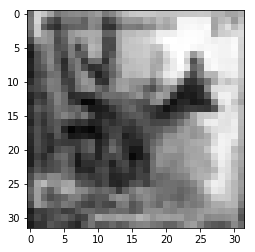

In [78]:
params = {}
params.update(defaultParams)

params['nbsteps'] = params['nbprescycles'] * ((params['prestime'] + params['interpresdelay']) * params['nbpatterns']) + params['prestimetest']
params['nbneur'] = params['patternsize'] + 1

inputs, target = generate_inputs_and_target(params)

imagesize = int(np.sqrt(params['patternsize']))
target_data = target.data.numpy().reshape((imagesize, imagesize))

plt.imshow(target_data, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)

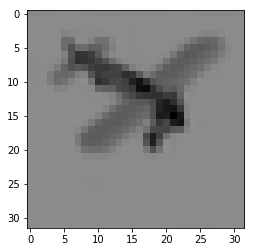

In [60]:
target_data = target.data.numpy().squeeze().reshape((imagesize, imagesize))

plt.imshow(target_data, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)

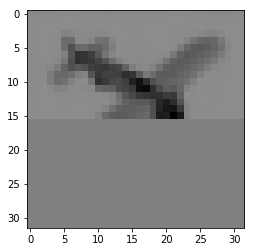

In [61]:
deg_img = inputs.data.numpy()[-1][0][:-1].reshape((imagesize, imagesize))

plt.imshow(deg_img, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)

# Network

In [81]:
class Network(nn.Module):
    def __init__(self, params):
        super(Network, self).__init__()

        # Notice that the vectors are row vectors, and the matrices are transposed
        # wrt the comp neuro order, following deep learning / pytorch conventions
        # Each *column* of w targets a single output neuron
        self.w = Variable(.01 * torch.randn(params['nbneur'], params['nbneur']).type(ttype), requires_grad=True)

        if params['homogenous'] == 1:
            # plasticity coefficients: homogenous/shared across connections
            self.alpha = Variable(.01 * torch.ones(1).type(ttype), requires_grad=True)
        else:
            # plasticity coefficients: independent
            self.alpha = Variable(.01 * torch.randn(params['nbneur'], params['nbneur']).type(ttype),
                                  requires_grad=True)

        # "learning rate" of plasticity, shared across all connections
        self.eta = Variable(.01 * torch.ones(1).type(ttype), requires_grad=True)
        self.params = params

    def forward(self, input, yin, hebb):
        # Inputs are fed by clamping the output of cells that receive
        # input at the input value, like in standard Hopfield networks
        # clamps = torch.zeros(1, self.params['nbneur'])
        clamps = np.zeros(self.params['nbneur'])
        zz = torch.nonzero(input.data[0].cpu()).numpy().squeeze()

        clamps[zz] = 1

        clamps = Variable(torch.from_numpy(clamps).type(ttype), requires_grad=False).float()
        yout = F.tanh(yin.mm(self.w + torch.mul(self.alpha, hebb))) * (1 - clamps) + input * clamps

        # bmm used to implement outer product
        hebb = (1 - self.eta) * hebb + self.eta * torch.bmm(yin.unsqueeze(2), yout.unsqueeze(1))[0]
        return yout, hebb

    def initialZeroState(self):
        return Variable(torch.zeros(1, self.params['nbneur']).type(ttype))

    def initialZeroHebb(self):
        return Variable(torch.zeros(self.params['nbneur'], self.params['nbneur']).type(ttype))

# Train

In [ ]:
print("Starting training...")
params = {}
params.update(defaultParams)

print("Passed params: ", params)
print(platform.uname())
sys.stdout.flush()

# Total number of steps per episode
params['nbsteps'] = params['nbprescycles'] * ((params['prestime'] + params['interpresdelay']) * params['nbpatterns']) + params['prestimetest']
params['nbneur'] = params['patternsize'] + 1

# Turning the parameters into a nice suffix for filenames; rngseed always appears last
suffix = "images_" + "".join([str(x) + "_"
                              if pair[0] is not 'nbneur'
                                 and pair[0] is not 'nbsteps'
                                 and pair[0] is not 'print_every'
                                 and pair[0] is not 'rngseed'
                              else ''
                              for pair in zip(params.keys(), params.values())
                              for x in pair])[:-1] + '_rngseed_' + str(params['rngseed'])

# Initialize random seeds (first two redundant?)
print("Setting random seeds")
np.random.seed(params['rngseed'])
random.seed(params['rngseed'])
torch.manual_seed(params['rngseed'])

print("Initializing network")
net = Network(params)
total_loss = 0.0

print("Initializing optimizer")
optimizer = torch.optim.Adam([net.w, net.alpha, net.eta], lr=params['lr'])
all_losses = []

nowtime = time.time()
print("Starting episodes...")
sys.stdout.flush()

for numiter in range(params['nbiter']):
    y = net.initialZeroState()
    hebb = net.initialZeroHebb()
    optimizer.zero_grad()

    inputs, target = generate_inputs_and_target(params)

    # Running the episode
    for numstep in range(params['nbsteps']):
        y, hebb = net.forward(Variable(inputs[numstep], requires_grad=False), y, hebb)

    # Computing gradients, applying optimizer
    loss = (y[0][:params['patternsize']] - Variable(target, requires_grad=False)).pow(2).sum()
    loss.backward()
    optimizer.step()

    lossnum = loss.data[0]
    total_loss += lossnum

    # Printing statistics, saving files
    if (numiter + 1) % params['print_every'] == 0:

        print(numiter, "====")
        td = target.cpu().numpy()
        yd = y.data.cpu().numpy()[0][:-1]

        print("y: ", yd[:10])
        print("target: ", td[:10])

        absdiff = np.abs(td - yd)

        print("Mean / median / max abs diff:", np.mean(absdiff), np.median(absdiff), np.max(absdiff))
        print("Correlation (full / sign): ", np.corrcoef(td, yd)[0][1], np.corrcoef(np.sign(td), np.sign(yd))[0][1])

        previoustime = nowtime
        nowtime = time.time()

        print("Time spent on last", params['print_every'], "iters: ", nowtime - previoustime)

        total_loss /= params['print_every']
        all_losses.append(total_loss)

        print("Mean loss over last", params['print_every'], "iters:", total_loss)
        print("Saving local files...")
        sys.stdout.flush()

        with open('results_' + suffix + '.dat', 'wb') as fo:
            pickle.dump(net.w.data.cpu().numpy(), fo)
            pickle.dump(net.alpha.data.cpu().numpy(), fo)
            pickle.dump(net.eta.data.cpu().numpy(), fo)
            pickle.dump(all_losses, fo)
            pickle.dump(params, fo)

        print("ETA:", net.eta.data.cpu().numpy())
        with open('loss_' + suffix + '.txt', 'w') as thefile:
            for item in all_losses:
                thefile.write("%s\n" % item)

        sys.stdout.flush()
        sys.stderr.flush()

        total_loss = 0

In [12]:
params = {}
params.update(defaultParams)

# Total number of steps per episode
params['nbsteps'] = params['nbprescycles'] * ((params['prestime'] + params['interpresdelay']) * params['nbpatterns']) + params['prestimetest']
params['nbneur'] = params['patternsize'] + 1


inputs, target = generate_inputs_and_target(params)

In [16]:
target.data.numpy()

array([0.5745, 0.503 , 0.3189, ..., 0.0826, 0.0936, 0.0716], dtype=float32)

In [18]:
plt.figure()
plt.imshow(target.data.numpy())

TypeError: Invalid dimensions for image data

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

# Predict

In [82]:
print("Starting training...")
params = {}
params.update(defaultParams)

# Total number of steps per episode
params['nbsteps'] = params['nbprescycles'] * ((params['prestime'] + params['interpresdelay']) * params['nbpatterns']) + params['prestimetest']
params['nbneur'] = params['patternsize'] + 1

Starting training...


In [101]:
fn = 'results/results_gpu.dat'

torch.load(fn, map_location='cpu')

with open(fn, 'rb') as fo:
    myw = pickle.load(fo)
    myalpha = pickle.load(fo)
    myeta = pickle.load(fo)
    myall_losses = torch.load(fo, map_location='cpu')
    myparams = pickle.load(fo)
    
net = Network(myparams)
net.w.data = torch.from_numpy(myw).type(ttype)
net.alpha.data = torch.from_numpy(myalpha).type(ttype)
net.eta.data = torch.from_numpy(myeta).type(ttype)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [84]:
NBPICS = 1 # 10 
nn = 1

imagesize = int(np.sqrt(myparams['patternsize']))

Running the episode...


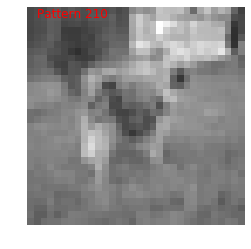

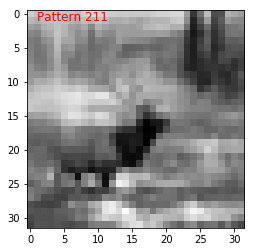

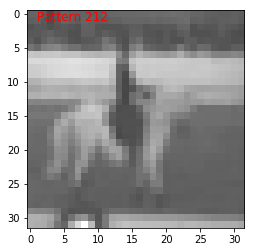

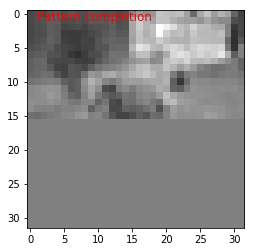

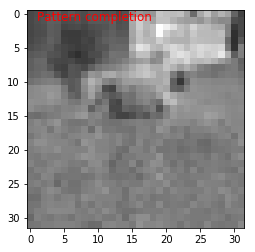

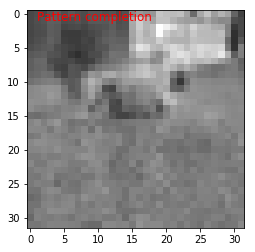

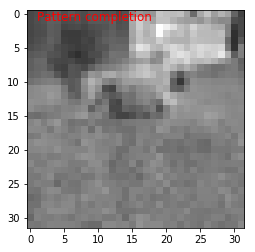

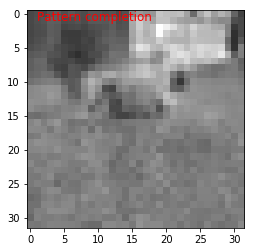

In [88]:
fig = plt.figure()
plt.axis('off')

for numpic in range(NBPICS):
    z = np.random.rand()
    z = np.random.rand()

    inputsTensor, targetPattern = generate_inputs_and_target(myparams, contiguousperturbation=True)

    y = net.initialZeroState()
    hebb = net.initialZeroHebb()
#     net.zeroDiagAlpha()

    ax_imgs = []

    print("Running the episode...")
    for numstep in range(myparams['nbsteps']):
        y, hebb = net(Variable(inputsTensor[numstep], requires_grad=False), y, hebb)
        output = y.data.cpu().numpy()[0][:-1].reshape((imagesize, imagesize))

        # Show the last set of 3 patterns, and the completion:
        if numstep ==  myparams['nbsteps'] - myparams['prestimetest'] - myparams['interpresdelay'] - 2 or \
                numstep ==  myparams['nbsteps'] - myparams['prestimetest'] - (myparams['interpresdelay'] + myparams['prestime']) - myparams['interpresdelay'] - 2 or \
                numstep ==  myparams['nbsteps'] - myparams['prestimetest'] - (myparams['interpresdelay'] + myparams['prestime']) *2 - myparams['interpresdelay'] - 2  or \
                numstep >= myparams['nbsteps'] - myparams['prestimetest'] :
            if numstep == myparams['nbsteps'] - myparams['prestimetest'] :
                output_half = output.copy()
                # NOTE: we are assuming that the grayed part will be the bottom one, which is only true for half the cases
                output_half[16:,:] = 0
                a1 = plt.imshow(output_half, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)
            else:
                a1 = plt.imshow(output, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)

            if numstep < myparams['nbsteps'] - myparams['prestimetest'] :
                a3 = plt.text(1, 1, "Pattern " + str(nn), fontsize=12, color='r')
            else:
                a3 = plt.text(1, 1, "Pattern completion", fontsize=12, color='r')
                
            plt.show()
            ax_imgs.append([a1, a3])  

            nn = nn + 1


#     print("Writing out the animation file")
#     anim = animation.ArtistAnimation(fig, ax_imgs, repeat_delay=2000)  # repeat_delay is ignored...
#     anim.save('anim_short_'+str(numpic)+'.gif', writer='imagemagick', fps=1)

Running the episode...


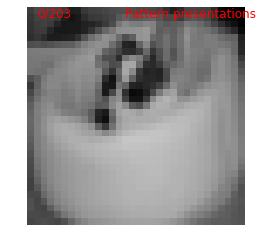

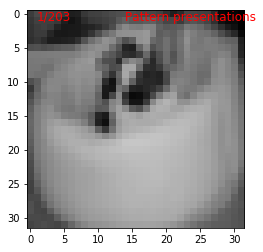

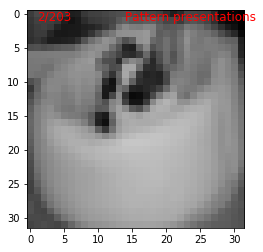

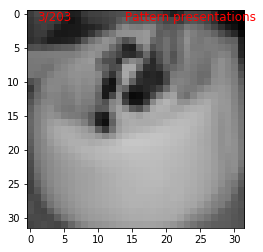

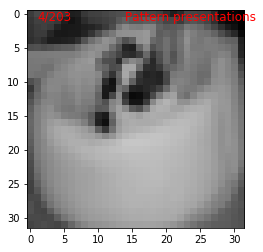

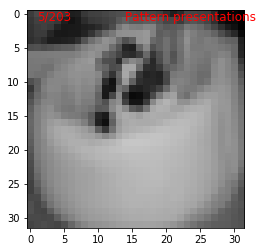

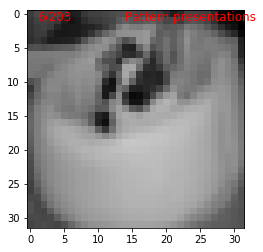

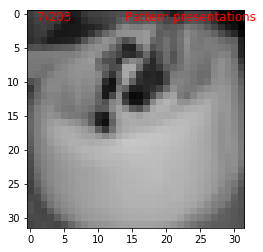

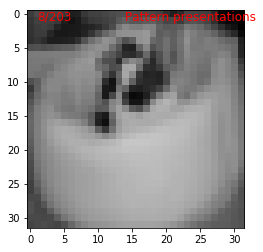

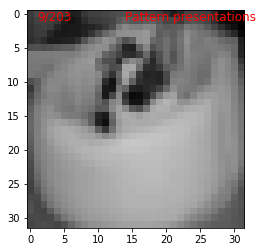

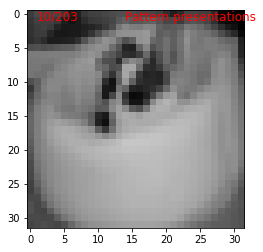

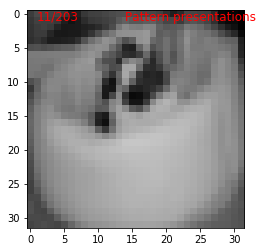

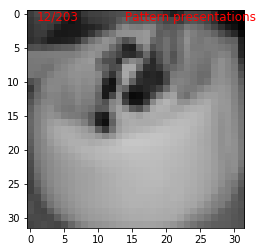

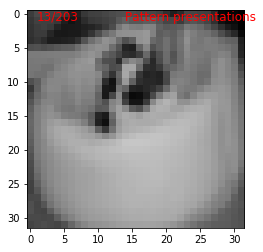

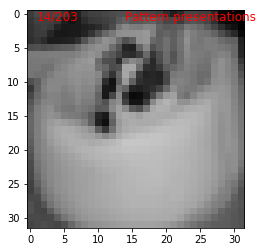

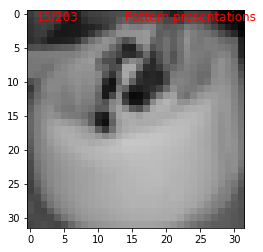

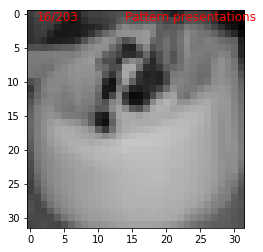

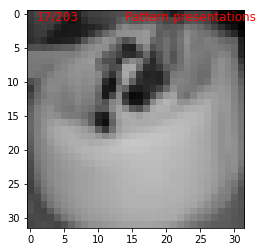

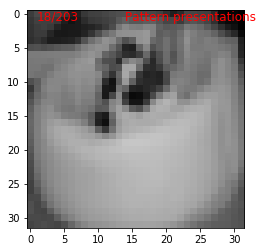

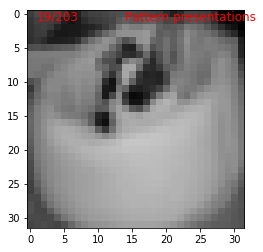

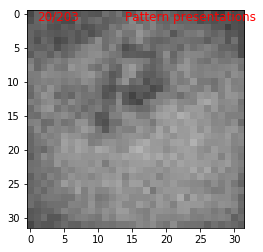

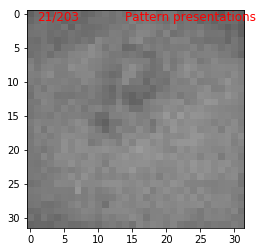

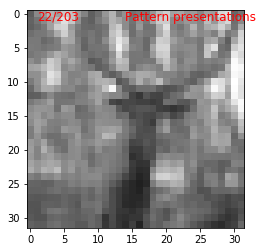

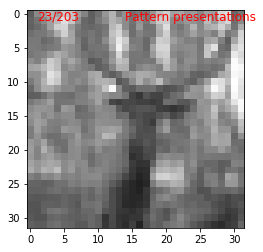

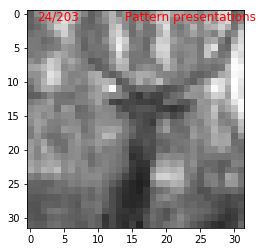

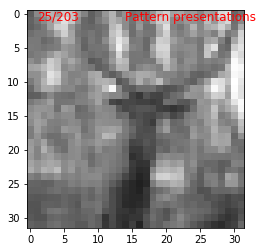

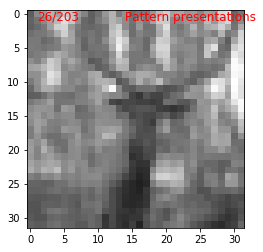

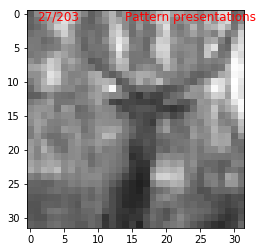

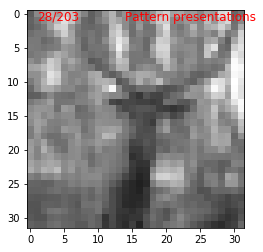

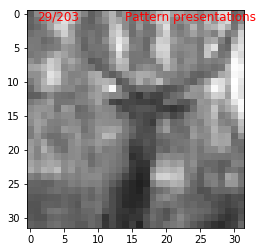

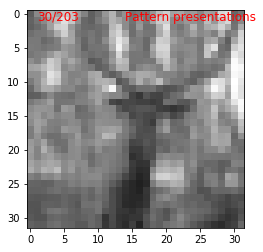

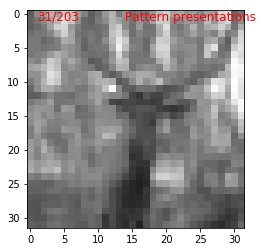

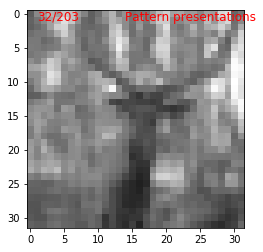

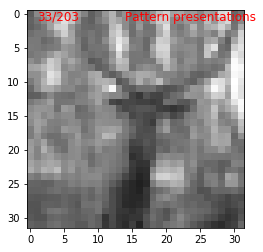

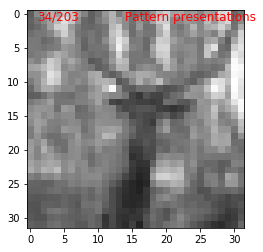

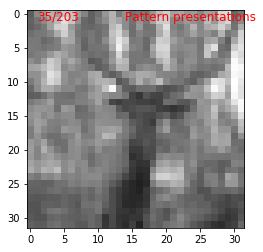

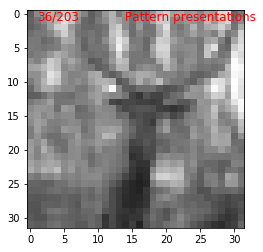

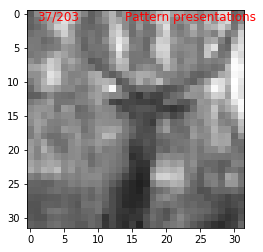

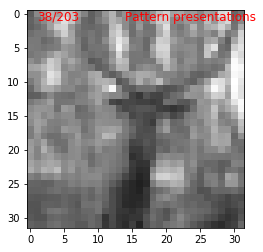

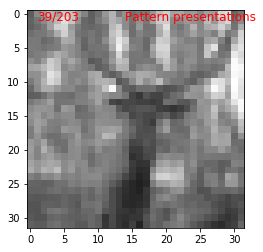

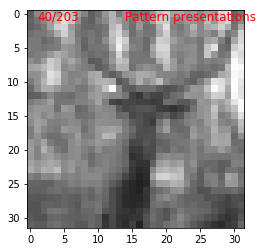

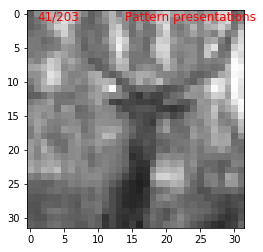

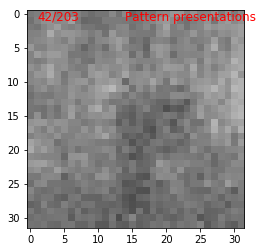

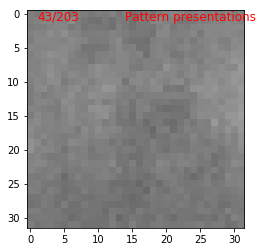

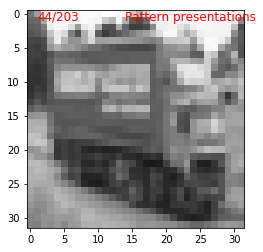

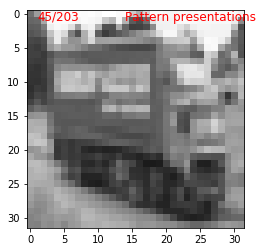

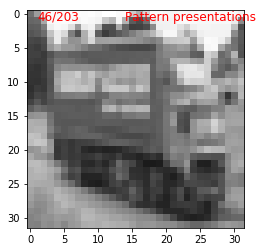

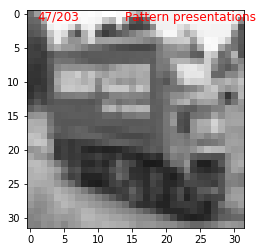

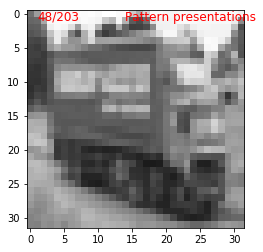

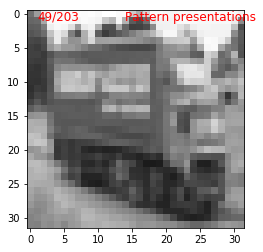

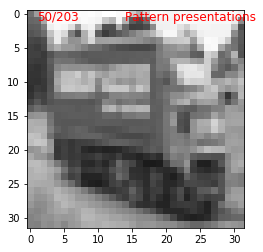

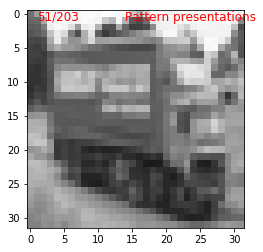

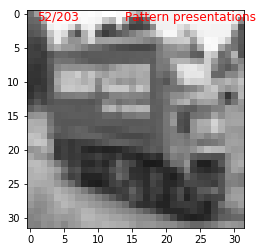

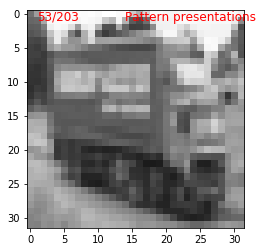

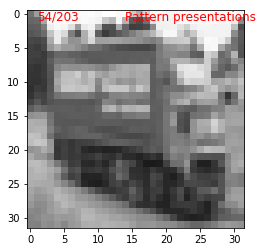

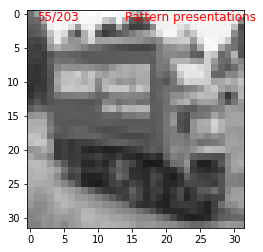

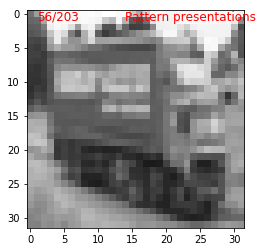

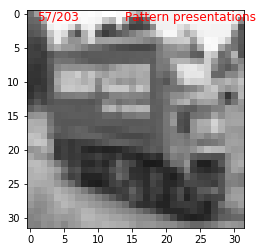

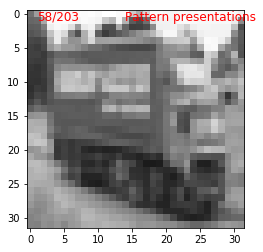

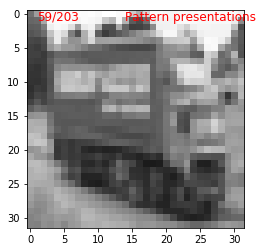

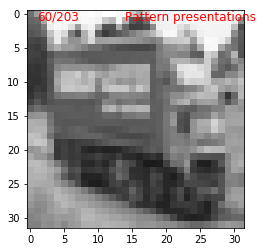

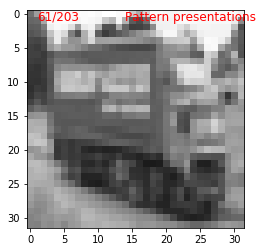

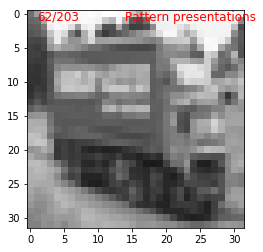

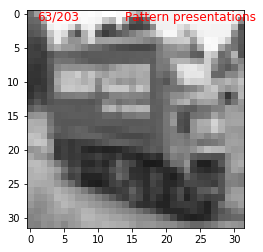

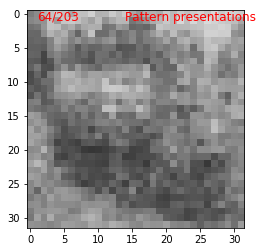

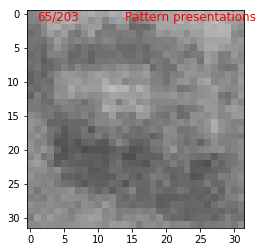

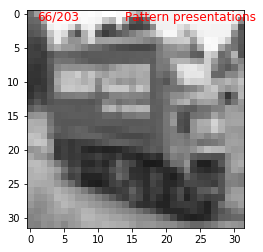

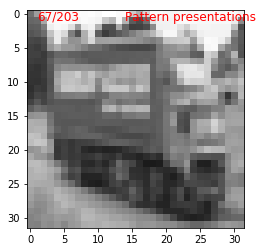

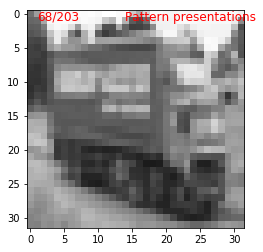

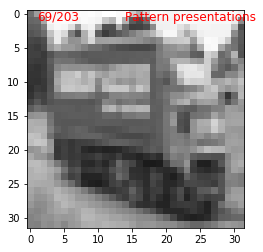

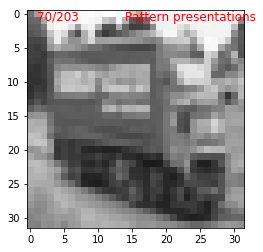

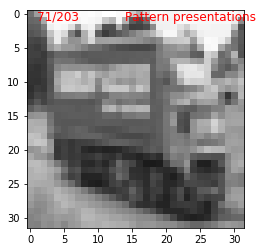

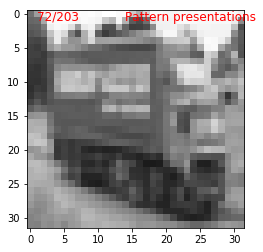

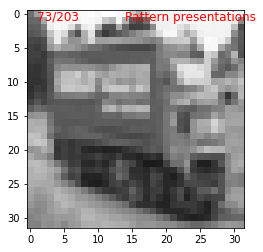

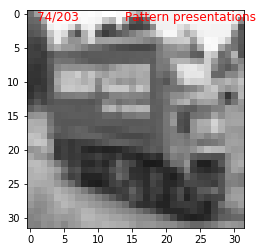

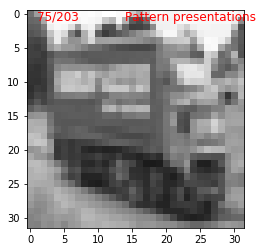

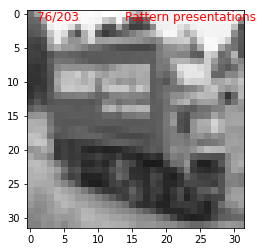

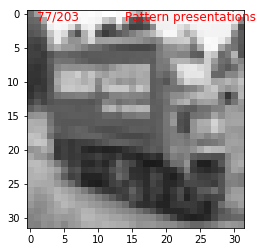

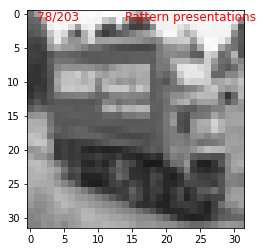

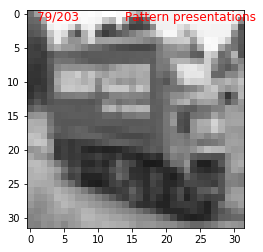

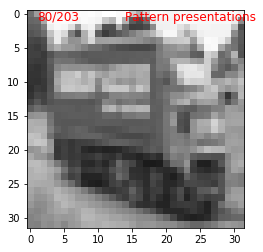

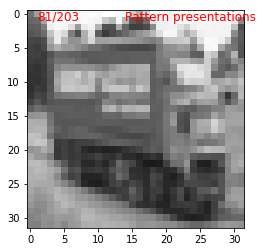

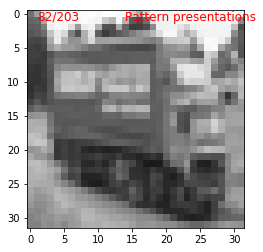

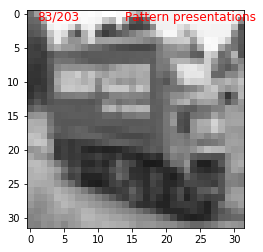

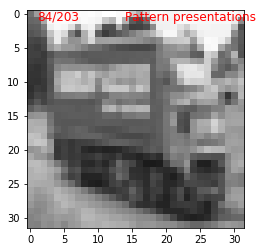

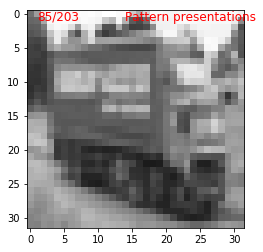

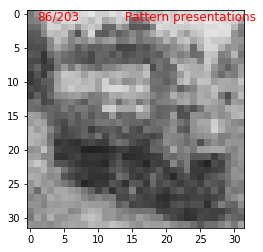

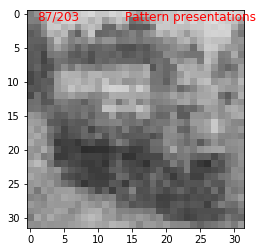

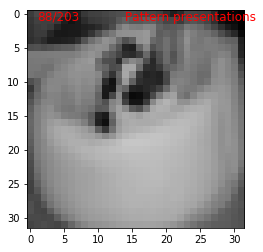

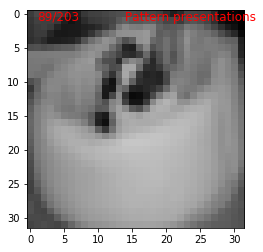

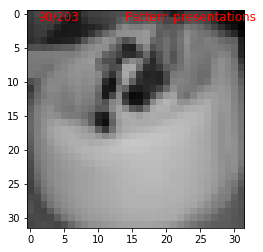

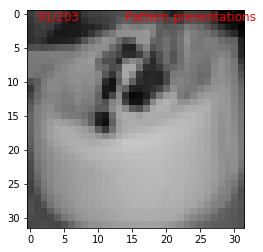

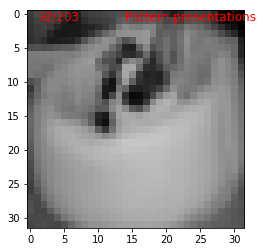

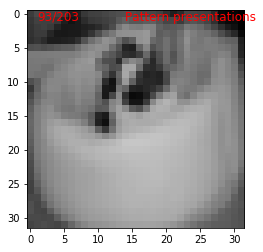

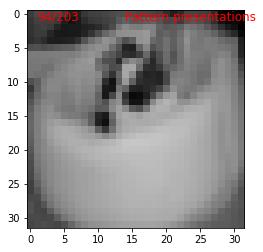

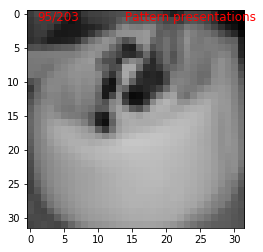

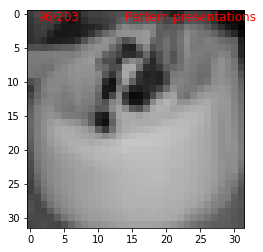

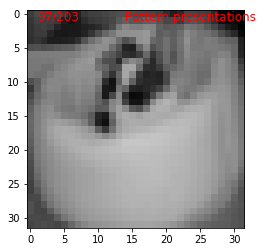

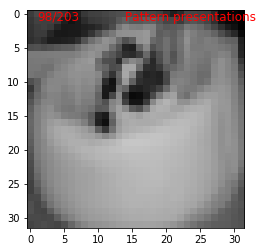

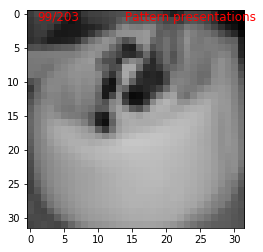

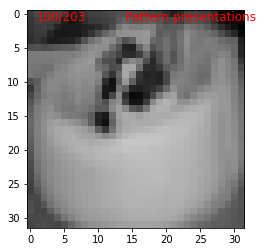

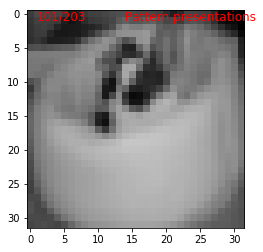

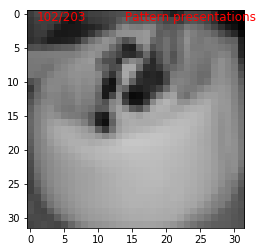

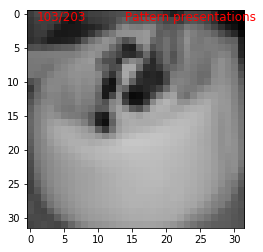

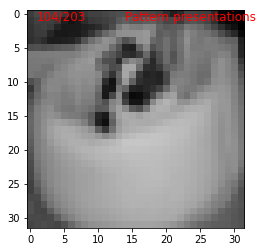

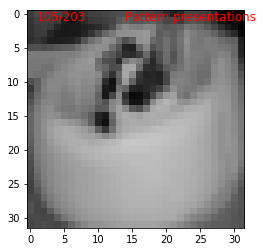

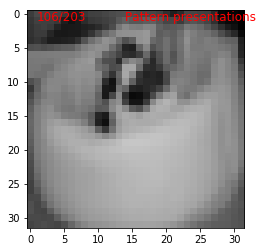

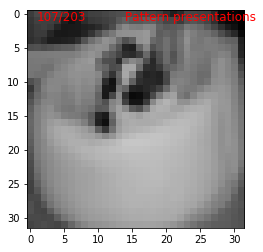

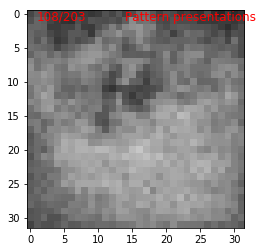

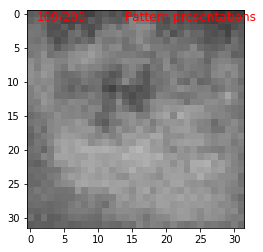

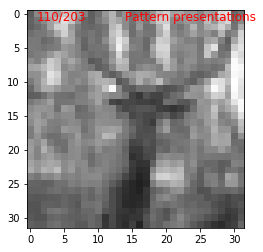

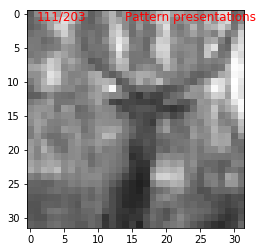

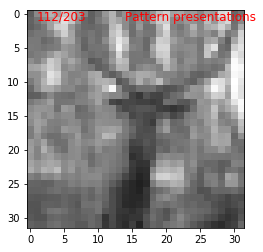

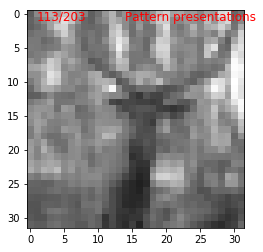

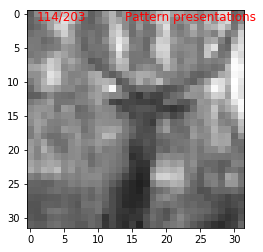

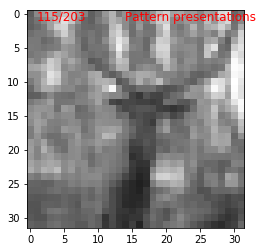

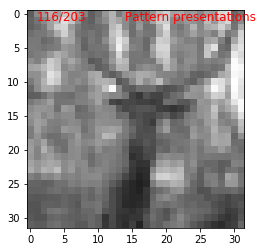

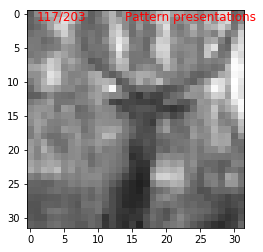

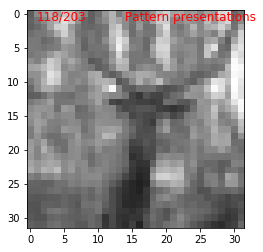

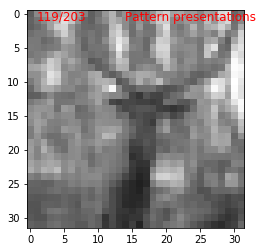

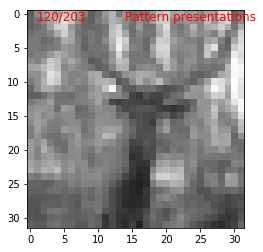

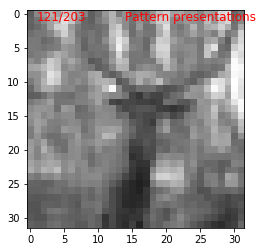

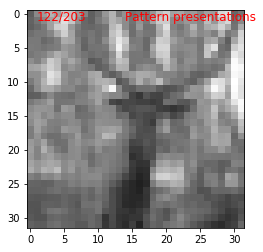

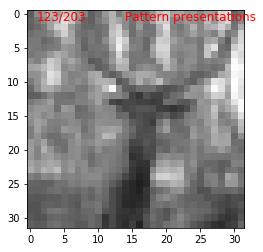

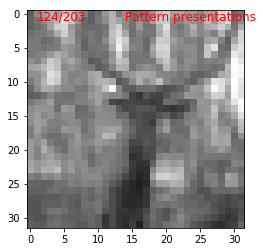

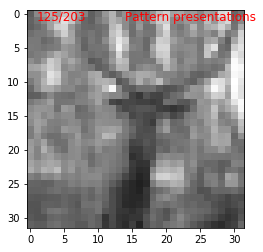

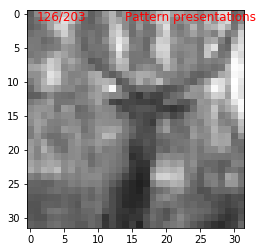

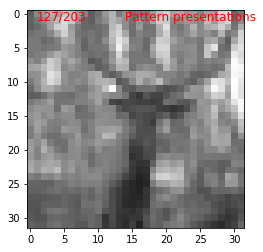

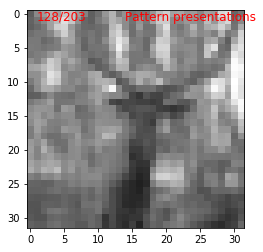

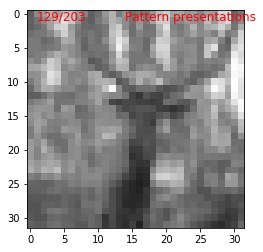

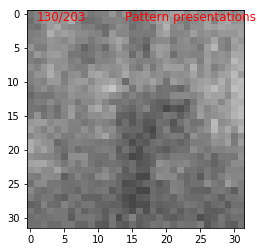

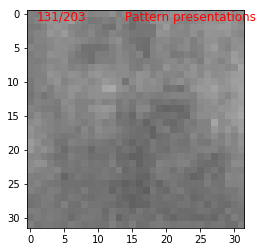

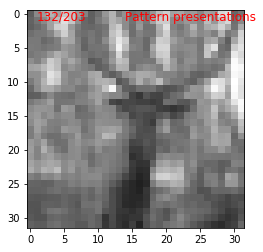

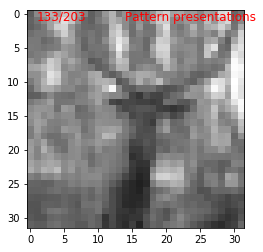

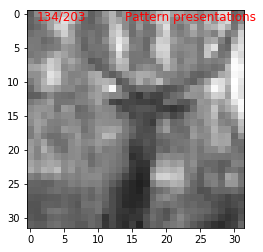

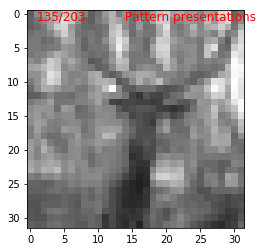

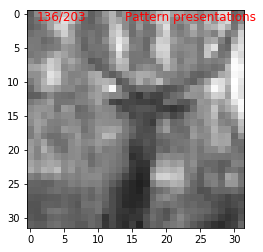

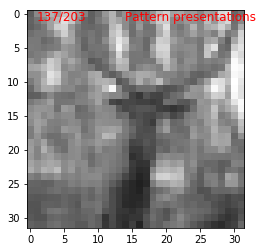

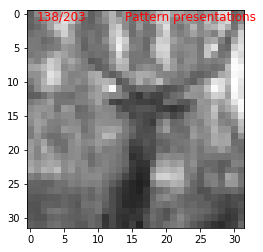

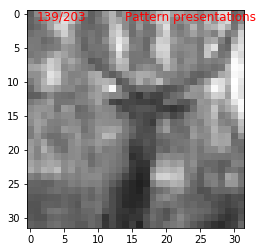

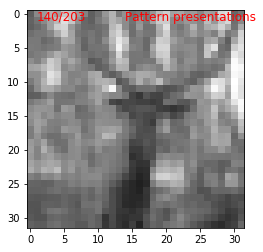

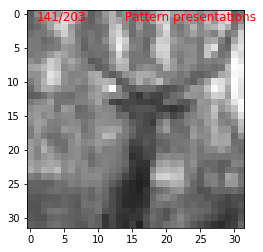

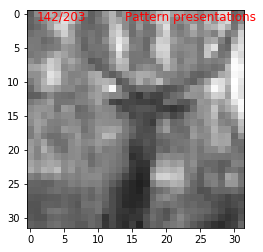

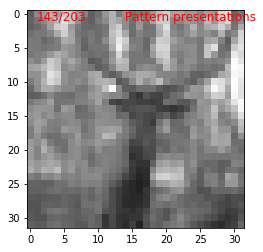

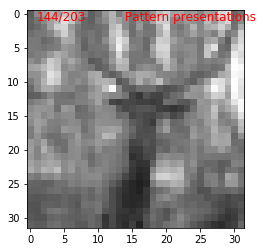

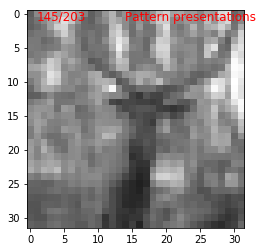

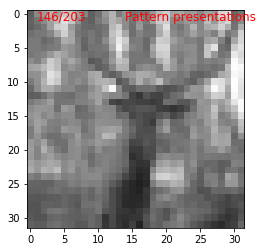

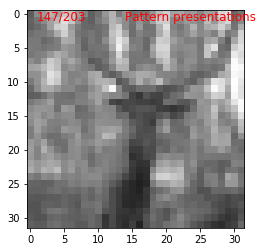

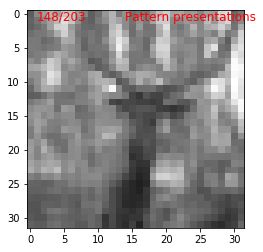

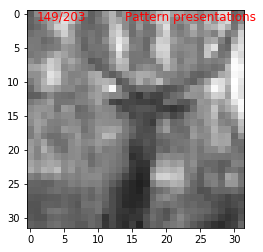

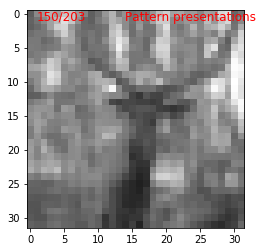

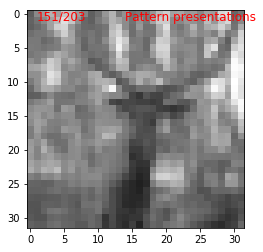

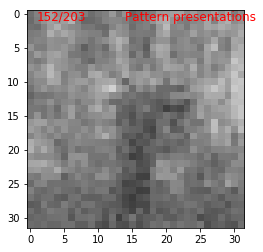

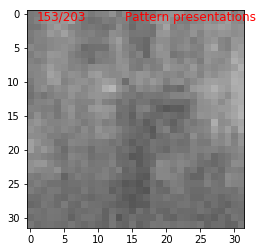

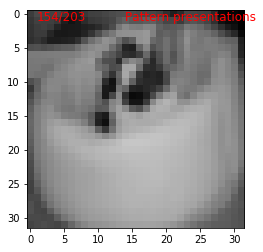

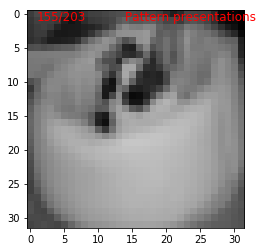

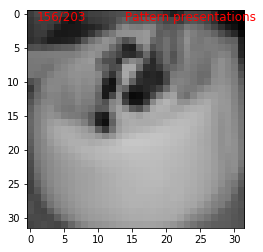

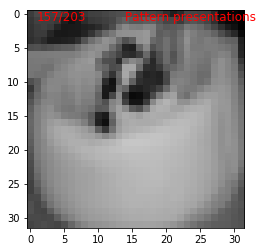

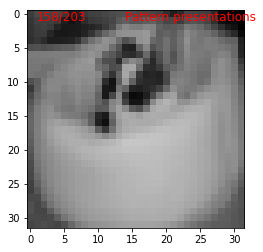

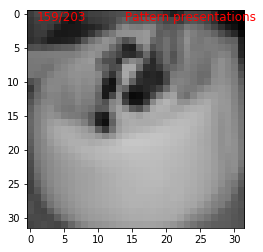

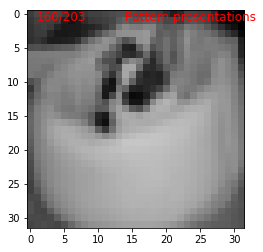

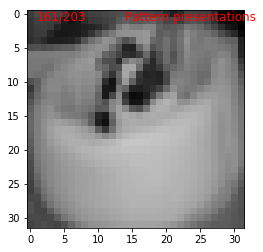

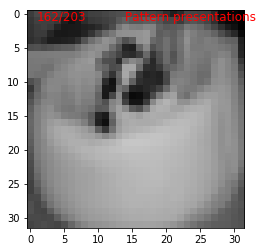

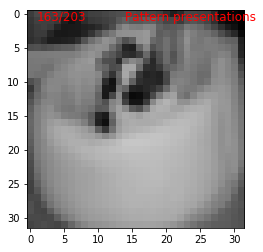

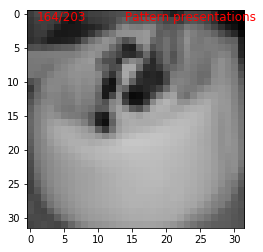

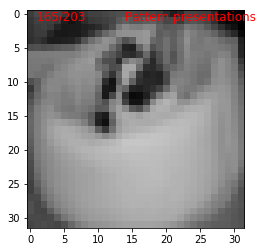

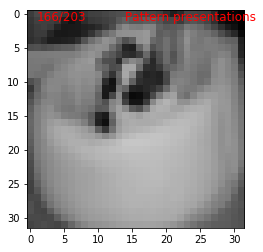

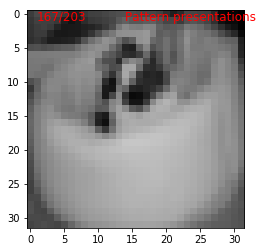

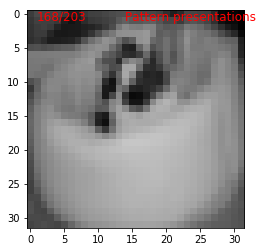

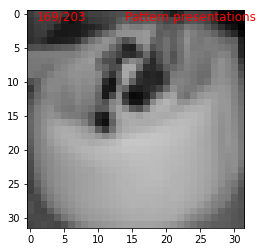

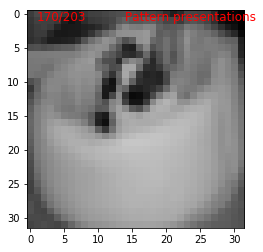

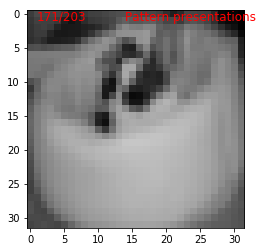

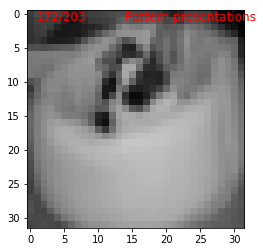

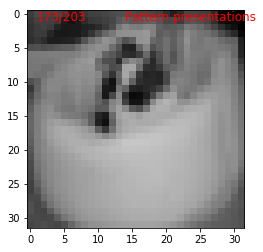

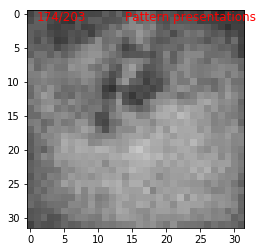

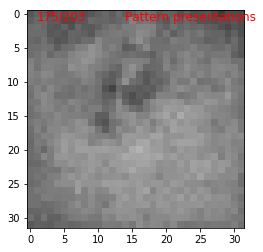

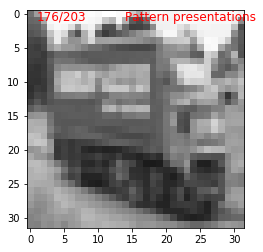

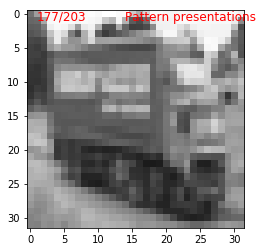

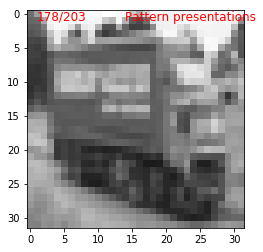

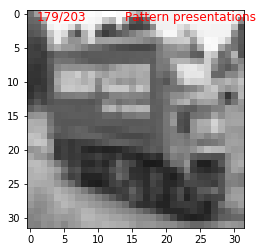

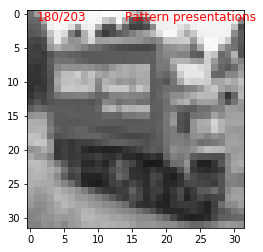

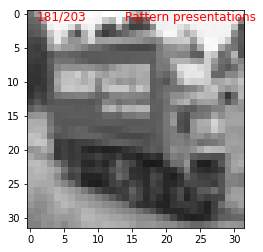

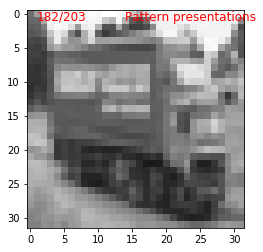

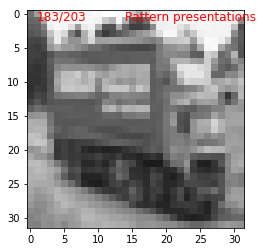

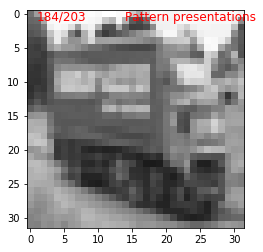

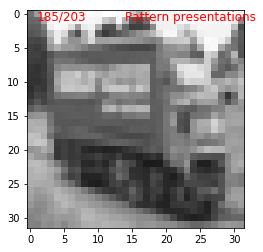

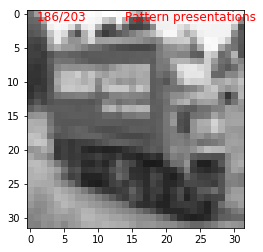

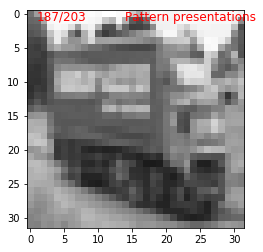

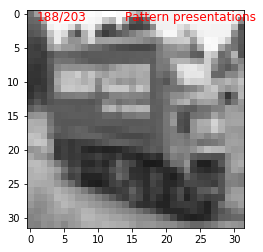

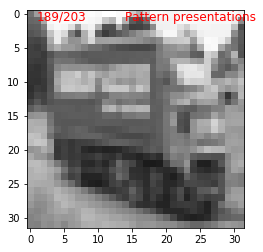

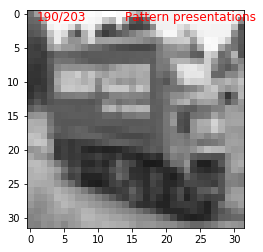

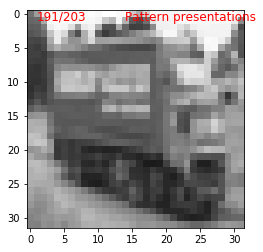

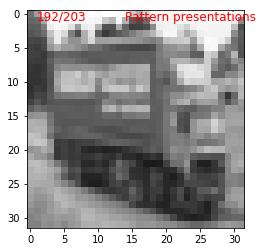

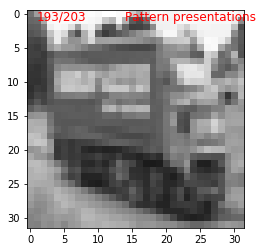

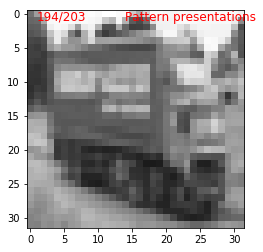

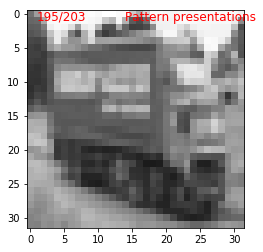

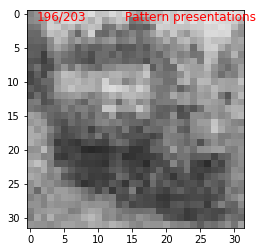

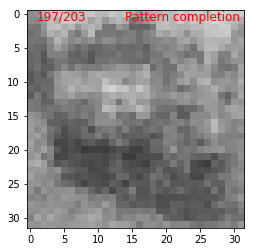

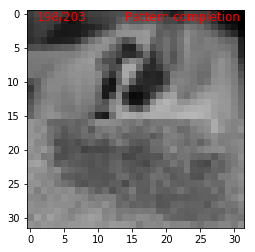

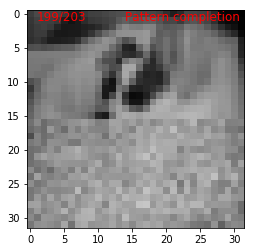

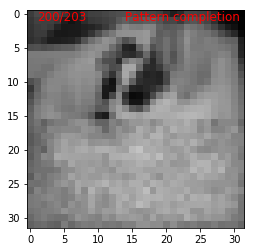

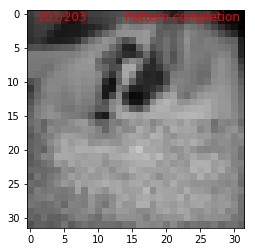

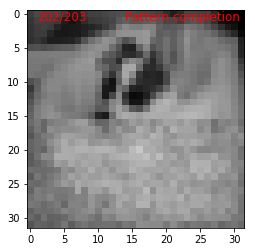

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


Writing out the animation file


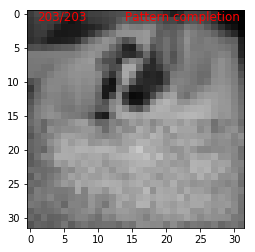

In [92]:
fig = plt.figure()
plt.axis('off')
        
for numpic in range(NBPICS):
    z = np.random.rand()
    z = np.random.rand()

    inputsTensor, targetPattern = generate_inputs_and_target(myparams, contiguousperturbation=True)

    y = net.initialZeroState()
    hebb = net.initialZeroHebb()
#     net.zeroDiagAlpha()

    ax_imgs = []

    print("Running the episode...")
    for numstep in range(myparams['nbsteps']):
        y, hebb = net(Variable(inputsTensor[numstep], requires_grad=False), y, hebb)
        output = y.data.cpu().numpy()[0][:-1].reshape((imagesize, imagesize))
        
        a1 = plt.imshow(output, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)
        a2 = plt.text(1, 1, str(numstep)+"/"+str(myparams['nbsteps']), fontsize=12, color='r')
        if numstep < myparams['nbsteps'] - myparams['prestimetest'] -  1:
            a3 = plt.text(14, 1,  "Pattern presentations", fontsize=12, color='r')
        else:
            a3 = plt.text(14, 1, "Pattern completion", fontsize=12, color='r')
        ax_imgs.append([a1, a2, a3])
        
        plt.show()

        nn += 1

    for numstep_add in range(50):
        a1 = plt.imshow(output, animated=True, cmap='gray', vmin=-1.0, vmax=1.0)
        a2 = plt.text(1, 1, str(myparams['nbsteps'])+"/"+str(myparams['nbsteps']), fontsize=12, color='r')
        a3 = plt.text(14, 1, "Pattern completion", fontsize=12, color='r')
        ax_imgs.append([a1, a2, a3]) 

    print("Writing out the animation file")
    anim = animation.ArtistAnimation(fig, ax_imgs)
    anim.save('anim_full_'+str(numpic)+'.gif', fps=1)